In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/gaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/binnedFit_utilities.py
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from tfCube import *

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def line_pts(theta_deg):
    L = 10.
    thega_rad = theta_deg/180.*np.pi
    xp = L*np.cos(thega_rad)
    yp = L*np.sin(thega_rad)
    return [xp, -xp], [yp, -yp]

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sini = 0.761
gamma_p = 0.0
gamma_x = 0.0

In [3]:
eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=gamma_p)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=gamma_x)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.38499950250817866
slitAng_major_p: 0.0
slitAng_minor_p: 90.0


In [4]:
pars = tfCube.getParams(redshift = 0.2)

pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p]) #np.linspace(-np.pi/4., np.pi/2., 3)

pars['g1'] = gamma_p
pars['g2'] = gamma_x
pars['sini'] = sini

pars['nm_per_pixel'] = 0.025 # nm/pixel
pars['pixScale'] = 0.032     # arcsec/pixel
pars['Resolution'] = 6000 
pars['psfFWHM'] = 0.05
pars['throughput'] = 0.29
pars['slitWidth']  = 0.06
pars['slitOffset'] = 0.0
pars['expTime'] = 10000.
pars['area'] = 3.14*(1000./2.)**2


pars['linelist']['flux'][pars['linelist']['species'] == 'Halpha'] = 6e-24
pars['norm'] = 0.
pars['lambda_min'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] - 2
pars['lambda_max'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] + 2

pars['vcirc'] = 200.
pars['aspect'] = 0.2
pars['n_knots'] = 25
pars['knot_fraction']=0.
pars['half_light_radius'] = 0.5
pars['vscale'] = pars['half_light_radius']


pars['ngrid'] = 512
pars['image_size'] = 256

pars['type_of_observation'] = 'slit'


extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']

In [5]:
aperture = galsim.Image(pars['ngrid'], pars['ngrid'],scale=subGridPixScale)

In [6]:
pars_more = pars.copy()
pars_more['lambda_min'] = pars['lambda_min']*0.99
pars_more['lambda_max'] = pars['lambda_max']*1.01
norm = pars['norm']

spec = tfCube.getGalaxySpectrum(pars_more,norm=norm)
specPh = tfCube.convertToPhotons(spec)

obsLambda = np.arange(pars['lambda_min'],pars['lambda_max'],pars['nm_per_pixel'])
specInterp = interp1d(specPh['lambda'],specPh['photonRate'],kind='slinear')
obsSpecPh = np.empty(specPh.size,dtype=[('lambda',np.float),('photonRate',np.float)])
obsSpecPh['lambda'] = specPh['lambda']
obsSpecPh['photonRate'] = ( specInterp(specPh['lambda'])*
                            pars['expTime']*pars['area']*
                            pars['throughput']*pars['pixScale']**2 *
                            pars['nm_per_pixel'] )
obsInterp = interp1d(obsSpecPh['lambda'],obsSpecPh['photonRate'],kind='slinear')

skySpec = ( tfCube.getSky(obsLambda, specPh ) *
                pars['expTime']*pars['area']*
                pars['throughput']*
                pars['pixScale']**2 *
                pars['nm_per_pixel'] )

In [7]:
A = np.array([[1+pars['g1'], pars['g2']], [pars['g2'], 1-pars['g1']]])
A_inv = np.linalg.inv(A)

In [8]:
# make the velocity field parameters
c_kms = 2.99792458e5 # c, in km/s
extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']
grid1d = np.linspace(-extent/2.,extent/2.,pars['ngrid'])
X, Y = np.meshgrid(grid1d, grid1d)

#THETA = np.angle(X+1j*Y)
#R = getR(X, Y, pars=pars) 

X_0shear, Y_0shear = getXY_0shear(X, Y, A_inv)
THETA = np.angle(X_0shear+1j*Y_0shear)
R = getR(X_0shear, Y_0shear, pars=pars)

PHI = getPhi(THETA, pars=pars)
Vsh = pars['vcirc'] * pars['sini'] * np.cos(PHI) * np.arctan((R-pars['r_0'])/pars['vscale']) * (2 / (np.pi * c_kms))
Vsh_kms = Vsh*c_kms

In [9]:
THETA = np.angle(X+1j*Y)
R = getR(X, Y, pars=pars) 
PHI = getPhi(THETA, pars=pars)
V0 = pars['vcirc'] * pars['sini'] * np.cos(PHI) * np.arctan((R-pars['r_0'])/pars['vscale']) * (2 / (np.pi * c_kms))
V0_kms = V0*c_kms

### check velocity data cube in tfCube (in agreement with Miller13 arctan velocity curve)

id_x: 1
id_y: 110
X: -4.079968688845401
Y: -2.3325557729941293
V0: -107.52306374793386
Vsh: -107.52306374793386


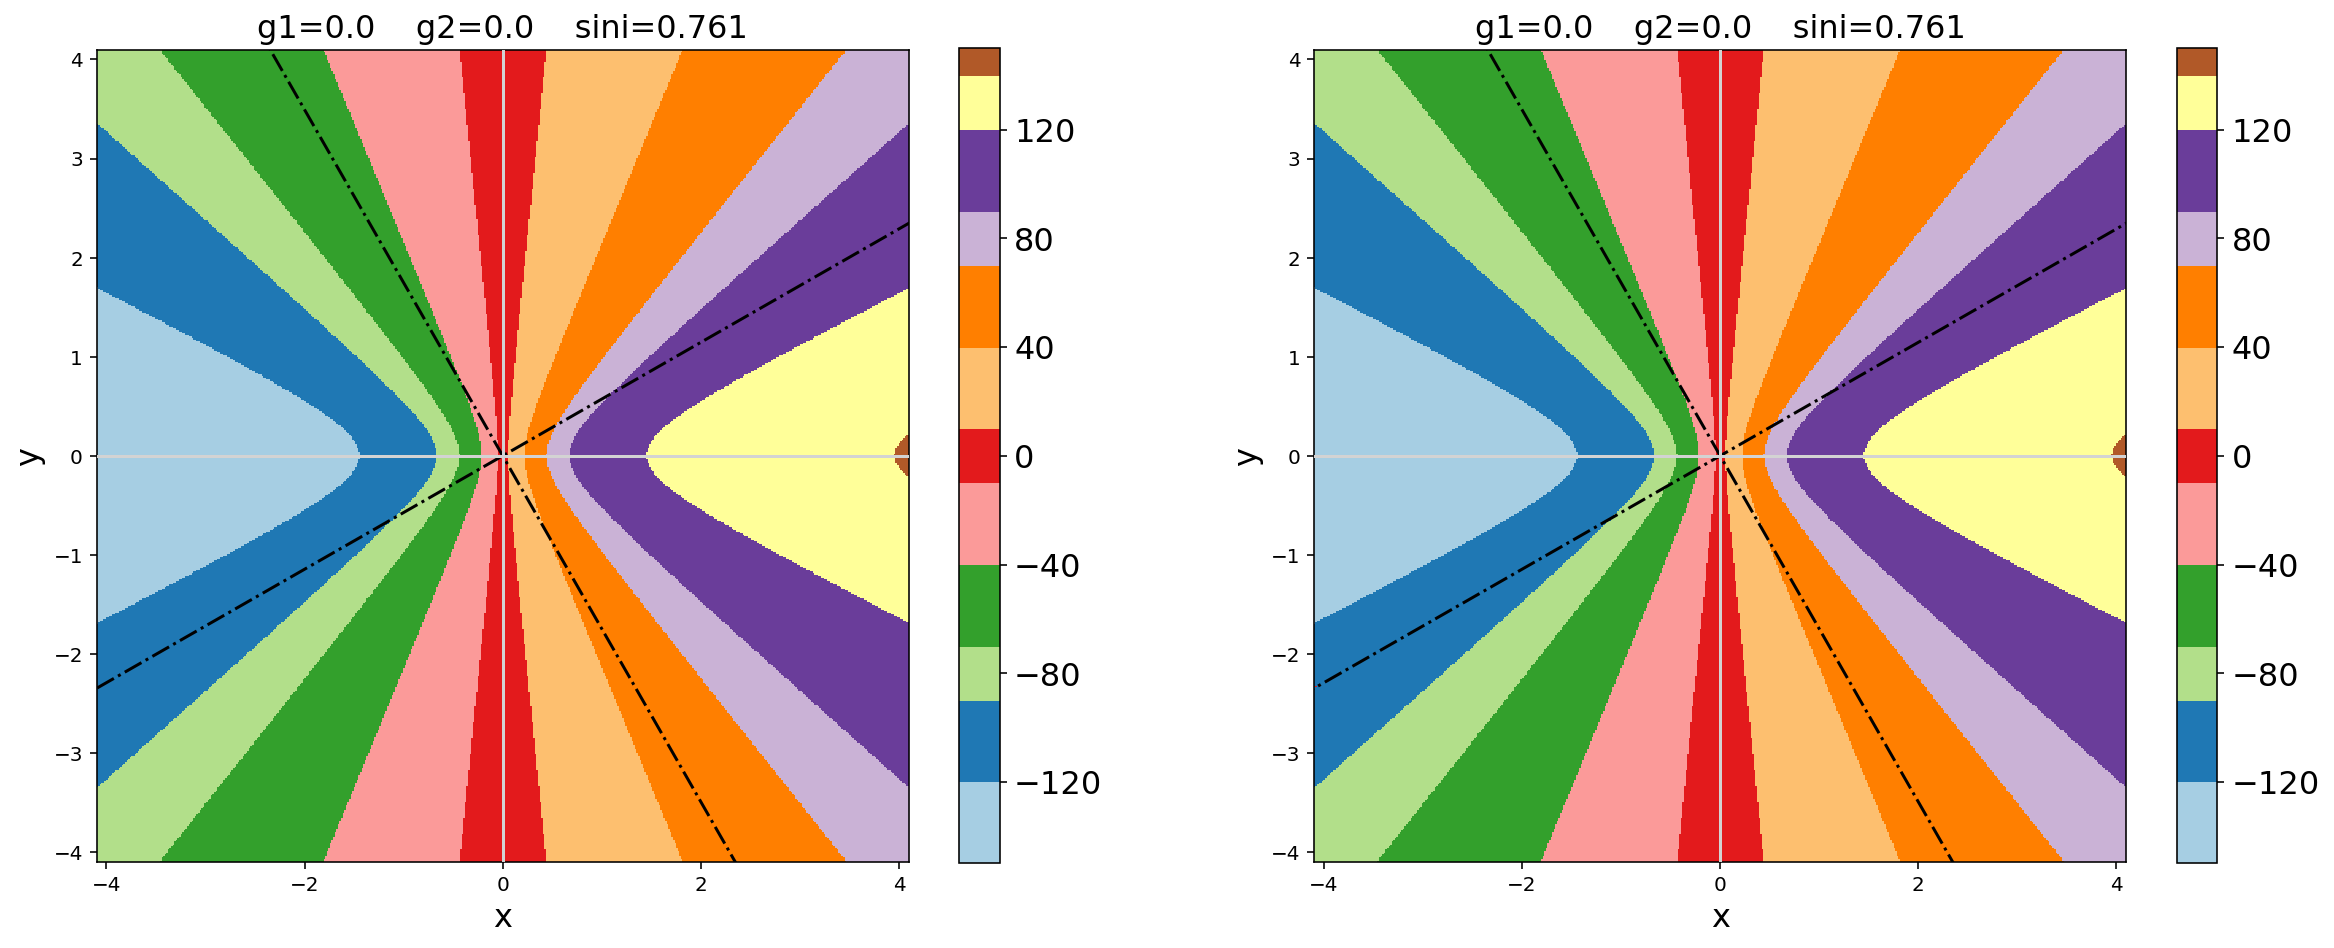

In [10]:
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(20., 7.5))
plt.rc('font',size=16)

levels = MaxNLocator(nbins=30).tick_values(-150., 150.)
norm = BoundaryNorm(levels, ncolors=plt.cm.Paired.N, clip=True)

########
id_x = 1 ; id_y = 110

Vsh_1xy = Vsh_kms[id_y, id_x]
V0_1xy =  V0_kms[id_y, id_x]

Vsh_kms_copy = Vsh_kms.copy()
V0_kms_copy = V0_kms.copy()
Vsh_kms_copy[id_y, id_x] = 0.
V0_kms_copy[id_y, id_x] = 0.

print("id_x:", id_x)
print("id_y:", id_y)
print("X:", X[id_y, id_x])
print("Y:", Y[id_y, id_x])
print("V0:", V0_1xy)
print("Vsh:", Vsh_1xy)

########


Vmap0 = ax[0].pcolormesh(X, Y, V0_kms_copy, cmap=plt.cm.Paired, norm=norm)
Vmap1 = ax[1].pcolormesh(X, Y, Vsh_kms_copy, cmap=plt.cm.Paired, norm=norm)


#Vmap = ax.pcolormesh(X, Y, Vsh_kms, cmap=plt.cm.jet, norm=norm)
#Vmap = ax.pcolormesh(X, Y, V0_kms, cmap=plt.cm.jet, norm=norm)
fig.colorbar(Vmap0, ax=ax[0])
fig.colorbar(Vmap1, ax=ax[1])


############

x_M, y_M = line_pts(theta_deg=29.7938)
x_m, y_m = line_pts(theta_deg=119.7938)


for j in range(2):
    ax[j].plot(x_M, y_M, color = 'k',ls='-.', label='g_x/e_int')
    ax[j].plot(x_m, y_m, color = 'k',ls='-.')
    
    axixlim = 4.096
    
    ax[j].set_xlim((-axixlim, axixlim))
    ax[j].set_ylim((-axixlim, axixlim))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel('x', fontsize=16)
    ax[j].set_ylabel('y', fontsize=16)
    ax[j].set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)
    
    ax[j].axhline(y=0,color='lightgray',zorder=3,lw=1.5)
    ax[j].axvline(x=0,color='lightgray',zorder=3,lw=1.5)

# ===== background corss ===== 

# ax.plot([-10, 10], [-10, 10], color = 'lightgray', zorder=-1,lw=0.5)
# ax.plot([ 10,-10], [-10, 10], color = 'lightgray', zorder=-1,lw=0.5)
# ax.grid(color='lightgray',linestyle='--')
# ============================


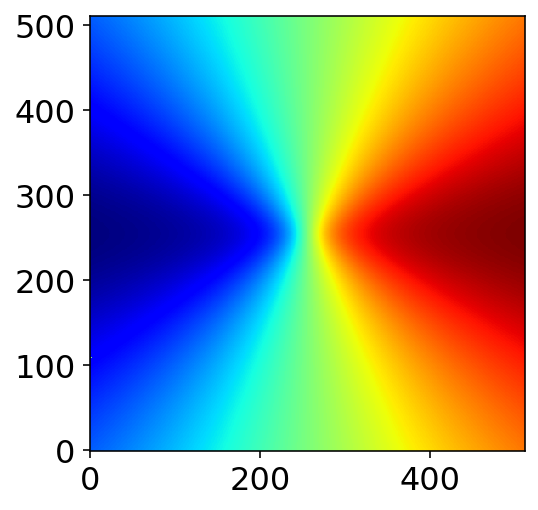

In [11]:
plt.imshow(Vsh_kms_copy,cmap=plt.cm.jet, origin='lower')

In [12]:
galIm, galObj, psf = getGalaxySlice(pars)
lambda_1d = np.arange(pars['lambda_min'], pars['lambda_max'], pars['nm_per_pixel'])
fluxGrid = np.empty([pars['ngrid'], pars['ngrid'], obsLambda.size])

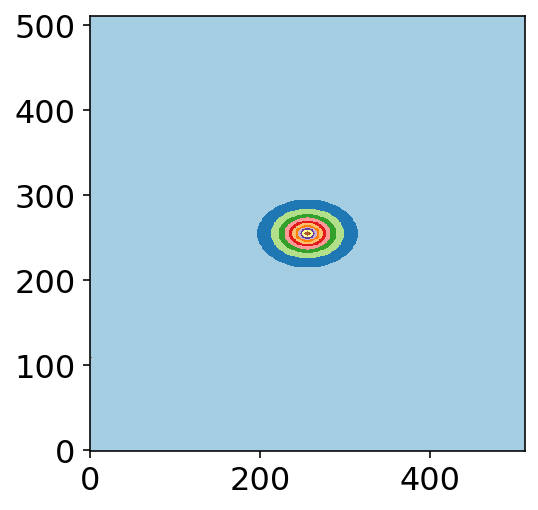

In [13]:
galIm_copy = galIm.array.copy()

id_x = 1 ; id_y = 110

galIm_copy[id_y, id_x] = galIm.array.max()

plt.imshow(galIm_copy,cmap=plt.cm.Paired, origin='lower')

In [14]:
v = Vsh.copy()
for i,x in enumerate(grid1d):
    for j,y in enumerate(grid1d):
        
        thisLambda = 1./(1 + v[j, i] ) * obsLambda
        thisSpec = obsInterp(thisLambda)*galIm.array[j,i]
        fluxGrid[j,i,:] = thisSpec

In [15]:
modelGrid = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
obsGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
skyGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])

for i in range(lambda_1d.size):
    thisIm = galsim.Image(np.ascontiguousarray(fluxGrid[:,:,i]), scale = subGridPixScale)
    
    newImage = thisIm.copy()
    noise = galsim.CCDNoise(sky_level = skySpec[i], read_noise = pars['read_noise'])
    modelGrid[:,:,i] = newImage.array
    skyGrid[:,:,i] = skySpec[i]
    noiseImage = newImage.copy()
    noiseImage.addNoise(noise)
    obsGrid[:,:,i]   = noiseImage.array

Text(0.5, 1.0, 'g1=0.0    g2=0.0    sini=0.761')

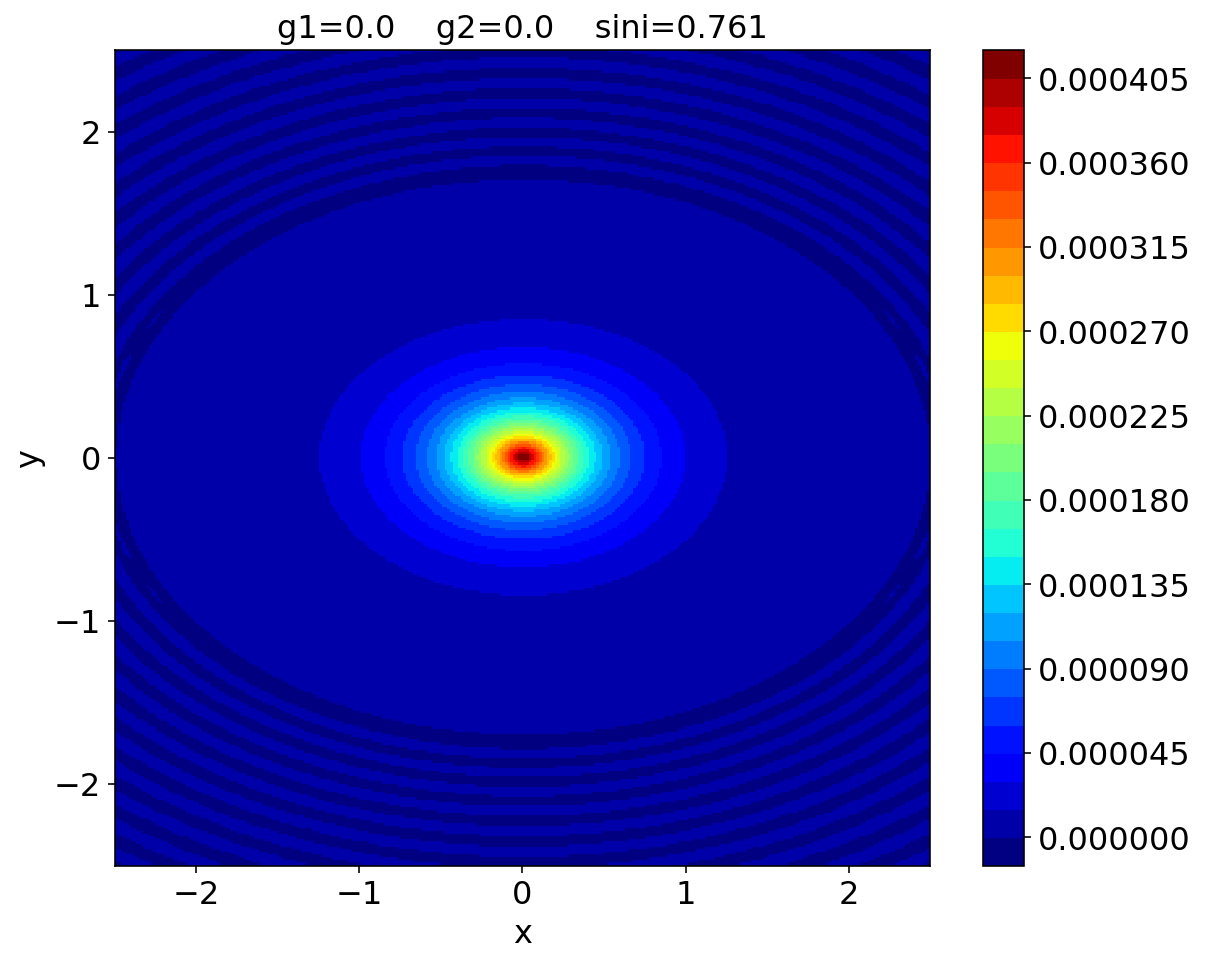

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9.5, 7.5))
plt.rc('font',size=16)


levels = MaxNLocator(nbins=30).tick_values(galIm.array.min(), galIm.array.max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

#levels = MaxNLocator(nbins=30).tick_values(X.min(), X.max())

gal = ax.pcolormesh(X, Y, galIm.array, cmap=plt.cm.jet, norm=norm)
#gal = ax.pcolormesh(X, Y, X, cmap=plt.cm.jet, norm=norm)


fig.colorbar(gal, ax=ax)

axixlim = 2.5
    
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)

Text(0.5, 1.0, 'g1=0.0    g2=0.0    sini=0.761')

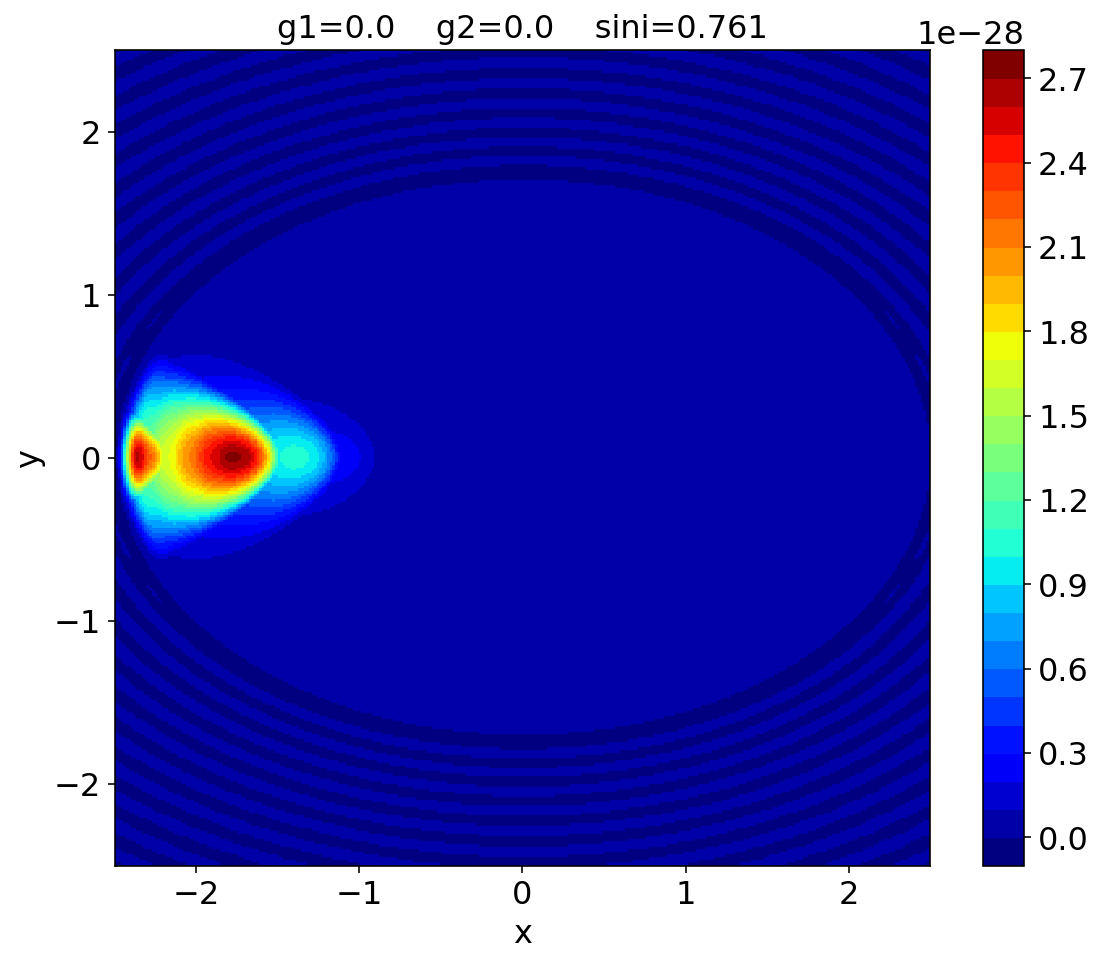

In [17]:
fig, ax = plt.subplots(1,1, figsize=(9.5, 7.5))
plt.rc('font',size=16)

ind=0

levels = MaxNLocator(nbins=30).tick_values(modelGrid[:,:,ind].min(), modelGrid[:,:,ind].max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

cube = ax.pcolormesh(X, Y, modelGrid[:,:,ind], cmap=plt.cm.jet, norm=norm)

fig.colorbar(cube, ax=ax)

axixlim = 2.5
    
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)

In [17]:
def getSlitSpectra(data=None, pars=None):
    # weights = getSlitWeights(pars)
    spectra = []
    extent = pars['image_size'] * pars['pixScale']
    subGridPixScale = extent*1./pars['ngrid']
    #grid = np.arange(-extent/2., extent/2., subGridPixScale)
    grid = np.linspace(-extent/2., extent/2., pars['ngrid'])
    
    # x and y slit offsets
    offset_x, offset_y = pars['offset_x'], pars['offset_y']
    xx,yy = np.meshgrid(grid-offset_x,grid-offset_y, indexing='ij')
    
    slit_weight = np.ones((pars['ngrid'], pars['ngrid']))
    slit_weight[np.abs(yy) > pars['slitWidth']/2.] = 0.
    
    for this_slit_angle in pars['slitAngles']:
        this_data = rotate(data, this_slit_angle*(180./np.pi), reshape=False)
        spectra.append(np.sum(this_data*slit_weight[:,:,np.newaxis],axis=0))
    return spectra

In [18]:
spectra = getSlitSpectra(data=modelGrid, pars=pars)

In [18]:
spectra = []
extent = pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']
#grid = np.arange(-extent/2., extent/2., subGridPixScale)
grid = np.linspace(-extent/2., extent/2., pars['ngrid'])
offset_x, offset_y = pars['offset_x'], pars['offset_y']
xx,yy = np.meshgrid(grid-offset_x,grid-offset_y)
slit_weight = np.ones((pars['ngrid'], pars['ngrid']))
slit_weight[np.abs(yy) > pars['slitWidth']/2.] = 0.

Text(0.5, 1.0, 'g1=0.0    g2=0.0    sini=0.761')

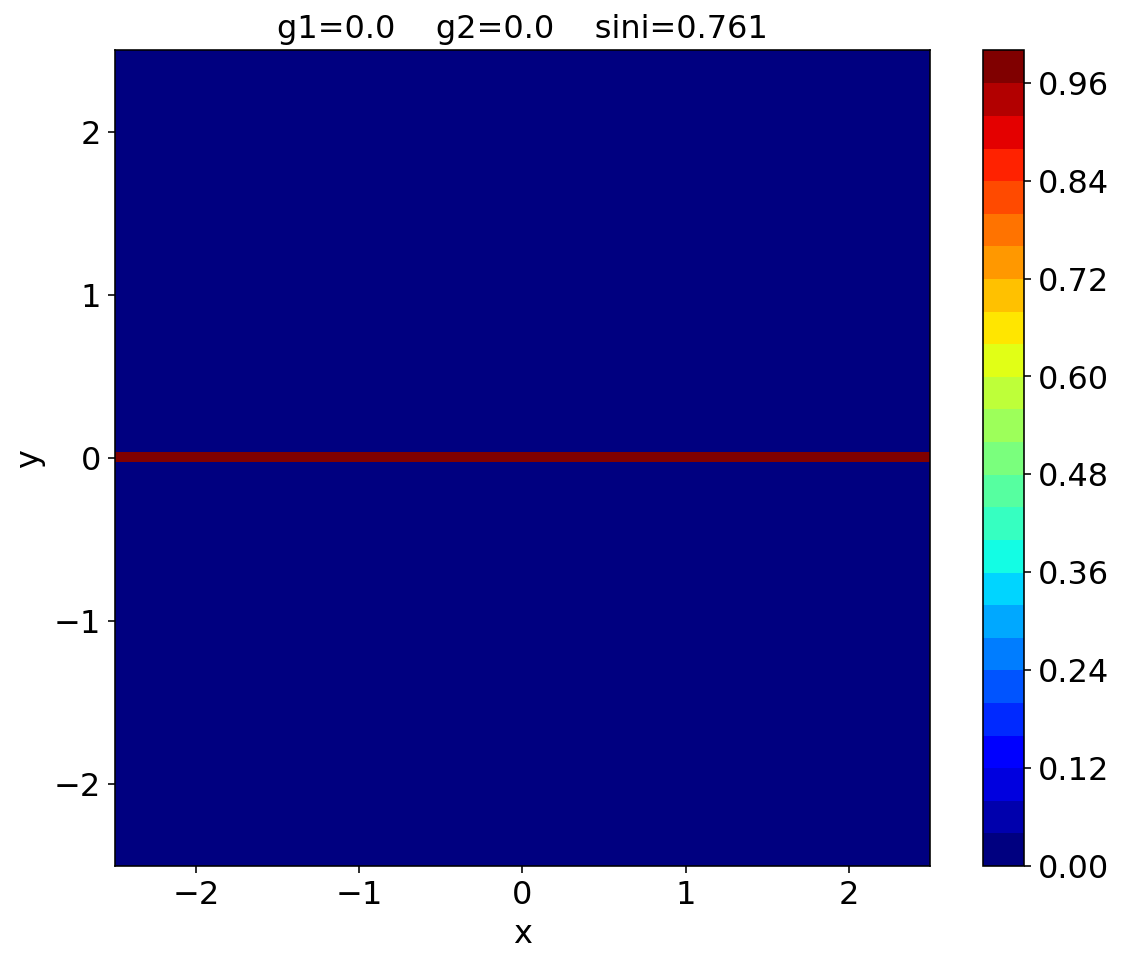

In [19]:
fig, ax = plt.subplots(1,1, figsize=(9.5, 7.5))
plt.rc('font',size=16)

levels = MaxNLocator(nbins=30).tick_values(slit_weight.min(), slit_weight.max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

cube = ax.pcolormesh(X, Y, slit_weight, cmap=plt.cm.jet, norm=norm)

fig.colorbar(cube, ax=ax)

axixlim = 2.5
    
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)

In [20]:
this_data = rotate(modelGrid, 20., reshape=False)
spectra.append(np.sum(this_data*slit_weight[:,:,np.newaxis],axis=0))

Text(0.5, 1.0, 'g1=0.0    g2=0.0    sini=0.761')

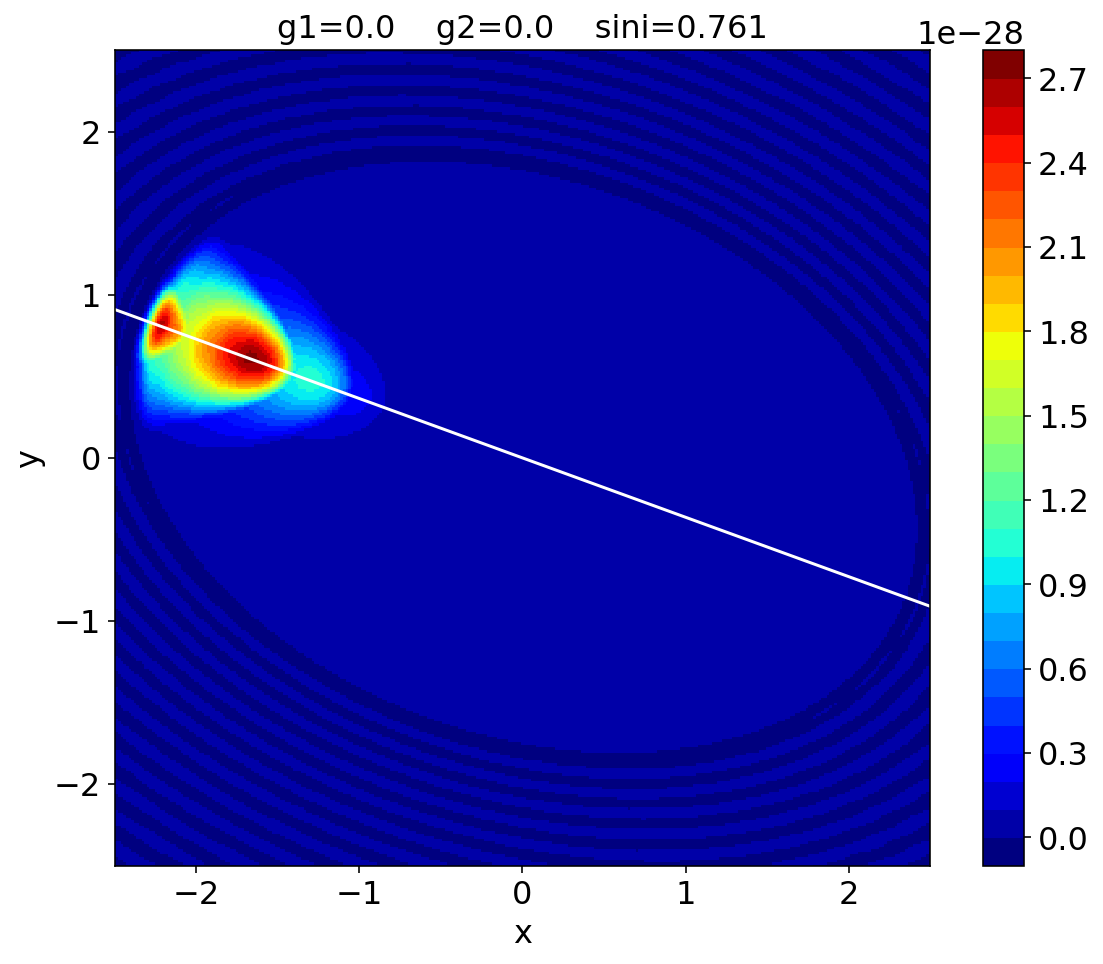

In [23]:
fig, ax = plt.subplots(1,1, figsize=(9.5, 7.5))
plt.rc('font',size=16)

ind = 0

levels = MaxNLocator(nbins=30).tick_values(modelGrid[:,:,ind].min(), modelGrid[:,:,ind].max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

cube = ax.pcolormesh(X, Y, this_data[:,:,ind], cmap=plt.cm.jet, norm=norm)

x_M, y_M = line_pts(theta_deg=-20.)
ax.plot(x_M, y_M, color='white')

fig.colorbar(cube, ax=ax)

axixlim = 2.5
    
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)

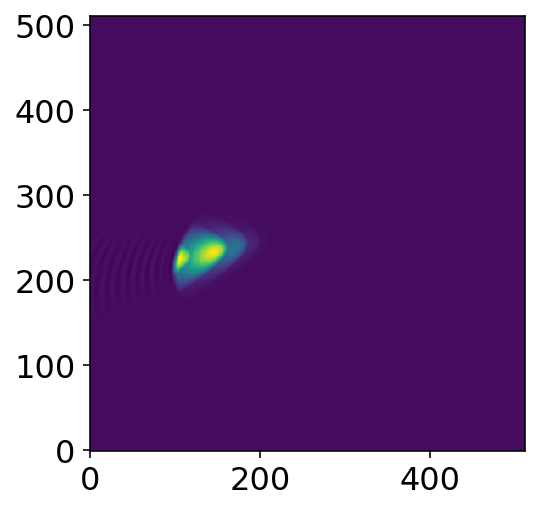

In [23]:
plt.imshow(modelGrid[:,:,0], origin='lower')

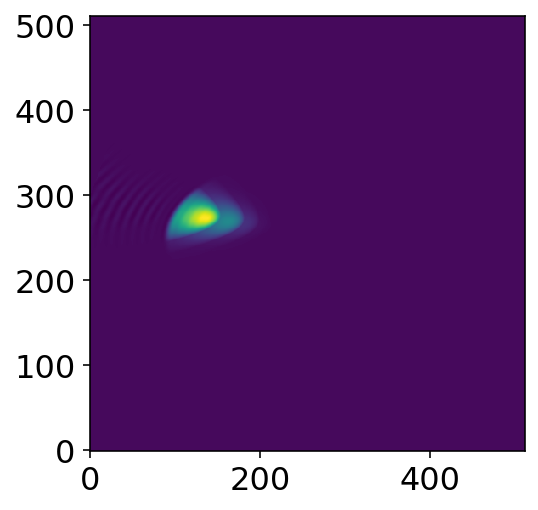

In [40]:
this_data = rotate(modelGrid, 20., reshape=False)
plt.imshow(this_data[:,:,0], origin='lower')

Text(0.5, 1.0, 'g1=0.0    g2=0.0    sini=0.761')

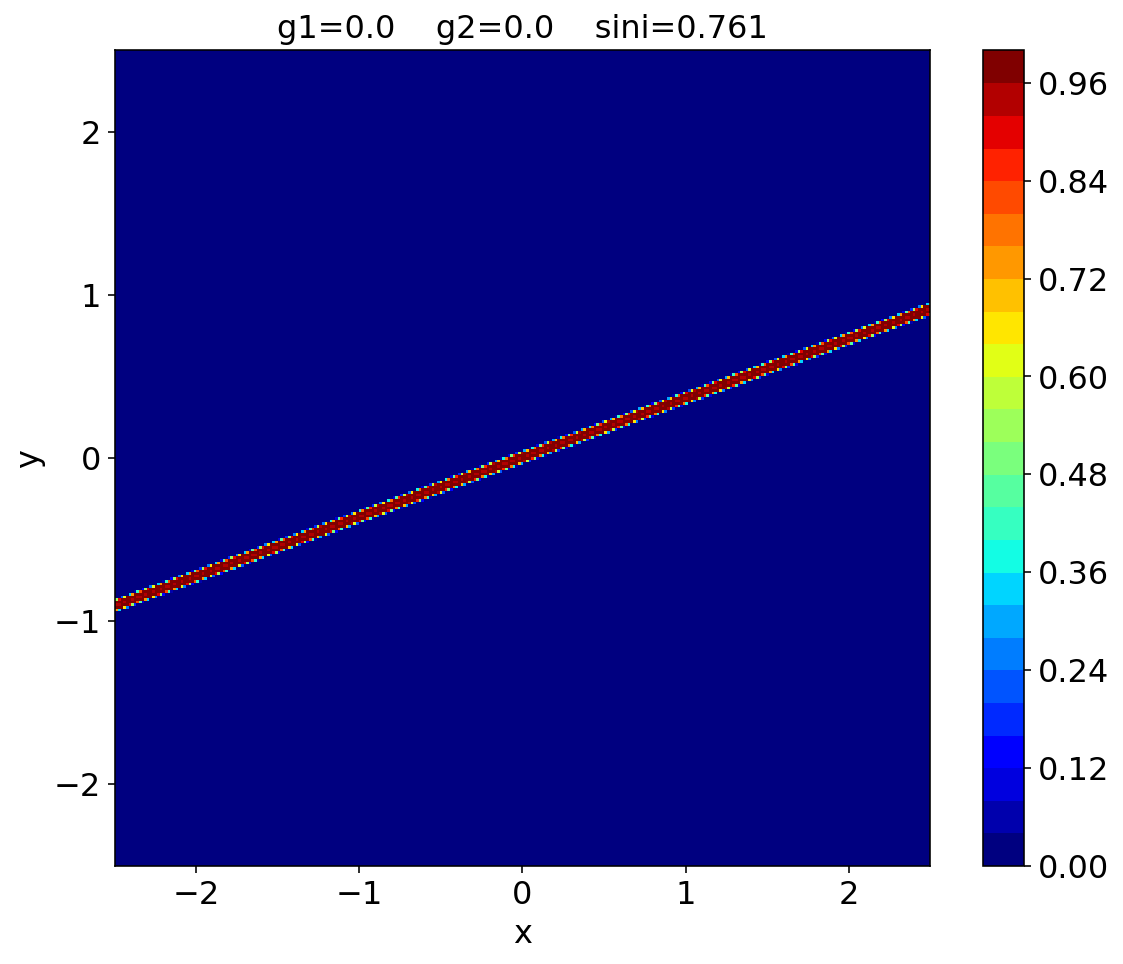

In [24]:
fig, ax = plt.subplots(1,1, figsize=(9.5, 7.5))
plt.rc('font',size=16)

levels = MaxNLocator(nbins=30).tick_values(slit_weight.min(), slit_weight.max())
norm = BoundaryNorm(levels, ncolors=plt.cm.jet.N, clip=True)

this_weight = rotate(slit_weight, -20., reshape=False)

cube = ax.pcolormesh(X, Y, this_weight, cmap=plt.cm.jet, norm=norm)

#x_M, y_M = line_pts(theta_deg=20.)
#ax.plot(x_M, y_M, color='white')

fig.colorbar(cube, ax=ax)

axixlim = 2.5
    
ax.set_xlim((-axixlim, axixlim))
ax.set_ylim((-axixlim, axixlim))
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title(f'g1={gamma_p}    g2={gamma_x}    sini={sini:.3f}', fontsize=16)

In [32]:
this_weight.max()

1.1137589652658004

In [33]:
this_weight.min()

-0.107258290139138

In [30]:
slit_weight.max()

1.0

In [31]:
slit_weight.min()

0.0

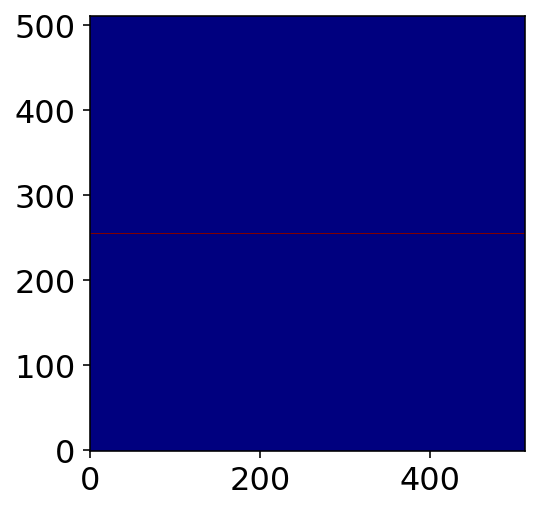

In [44]:
plt.imshow(slit_weight,cmap=plt.cm.jet, origin='lower')

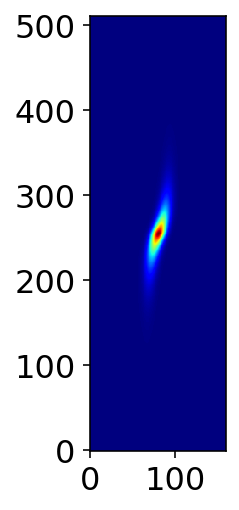

In [28]:
plt.imshow(spectra[0],cmap=plt.cm.jet, origin='lower')

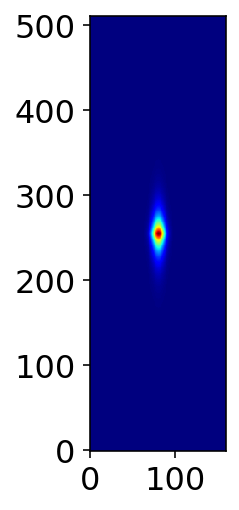

In [29]:
plt.imshow(spectra[1],cmap=plt.cm.jet, origin='lower')

In [51]:
len(spectra)

4

# ===== 

In [10]:
v_kms_1d = v[256,:]*c_kms
grid_pos = np.arange(-extent/2., extent/2., subGridPixScale)

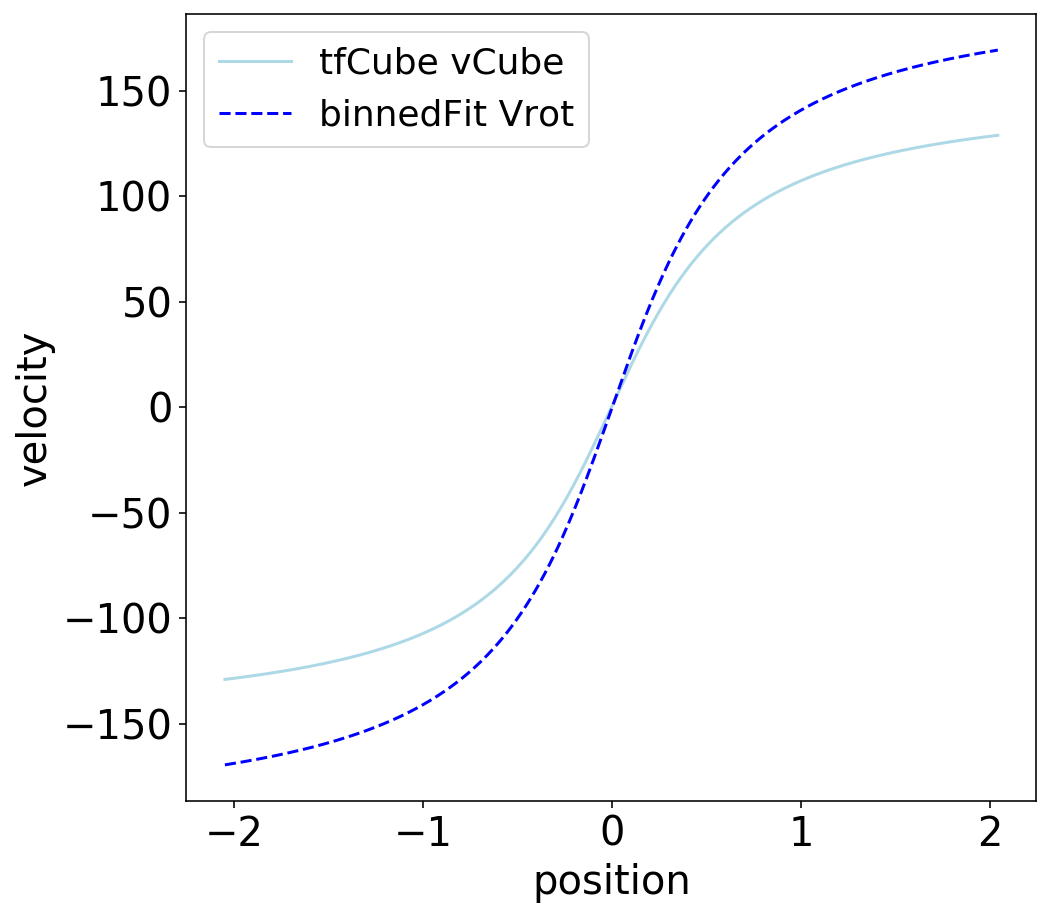

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, v_kms_1d, label='tfCube vCube', color='lightblue')

v_binnedFit = arctan_rotation_curve(r=grid_pos, r_0=0., vscale=0.5, v_0=0., v_spec=200.)
ax1.plot(grid_pos, v_binnedFit, label='binnedFit Vrot', color='b',ls='--')

ax1.set_xlabel('position')
ax1.set_ylabel('velocity')

ax1.legend(loc='best',prop={'size':18})

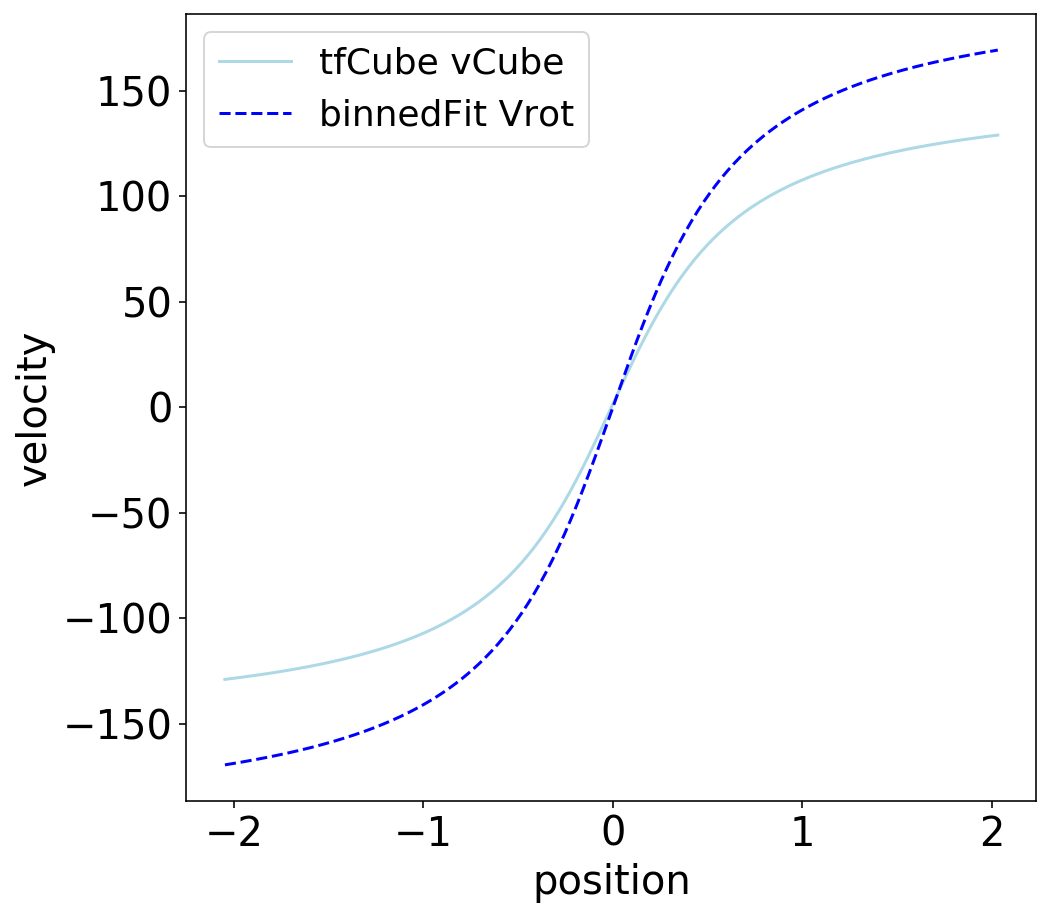

In [32]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, v_kms_1d, label='tfCube vCube', color='lightblue')

v_binnedFit = arctan_rotation_curve(r=grid_pos, r_0=0., vscale=0.5, v_0=0., v_spec=200.)

ax1.plot(grid_pos, v_binnedFit, label='binnedFit Vrot', color='b',ls='--')


ax1.set_xlabel('position')
ax1.set_ylabel('velocity')

ax1.legend(loc='best',prop={'size':18})

In [33]:
for i,x in enumerate(grid1d):
    for j,y in enumerate(grid1d):
        # This line here is where the disk velocity field enters.
        thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda
        thisSpec = obsInterp(thisLambda)*galIm.array[i,j] # this is the unsheared thing.
        fluxGrid[i,j,:] = thisSpec # currently in units of photon flux
# Shear the results and project them onto the output grid.
idealGrid = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
obsGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
skyGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])

psf = psf.shear(g1=pars['psf_g1'],g2 = pars['psf_g2'])
#psf = psf.dilate(1.02)
psfInv = galsim.Deconvolve(psf)

NameError: name 'phi' is not defined

In [16]:
pars['sini']

1.0

### check at the major axes direction cos(phi)

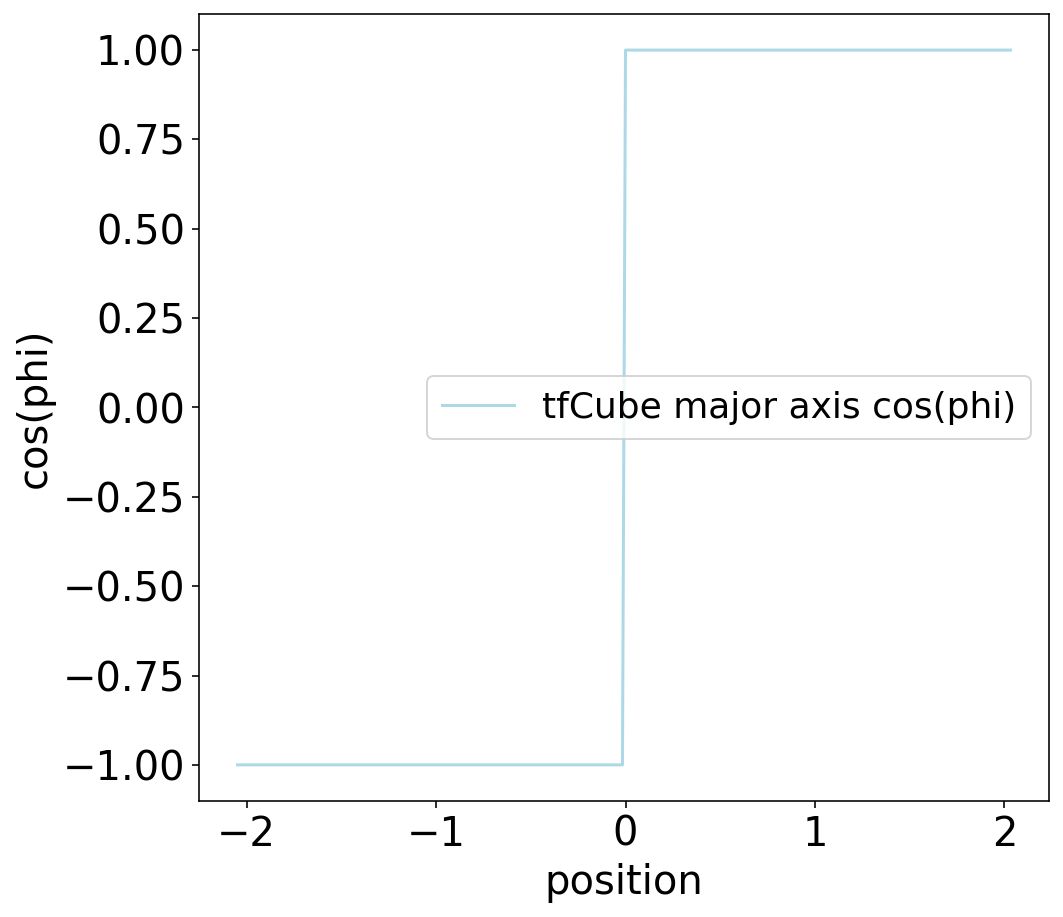

In [35]:

%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, np.cos(phi[128,:]), label='tfCube major axis cos(phi)', color='lightblue')

ax1.set_xlabel('position')
ax1.set_ylabel('cos(phi)')

ax1.legend(loc='best',prop={'size':18})

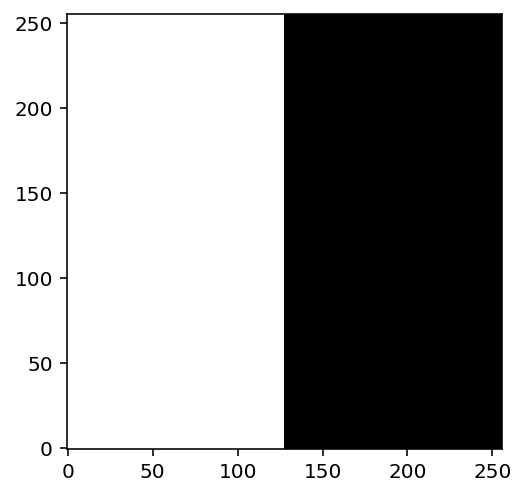

In [36]:
%matplotlib inline
plt.imshow(np.cos(phi),cmap=plt.cm.Greys,origin="lower")

In [17]:
redshift_2D_map = v *pars['sini']*np.cos(phi)

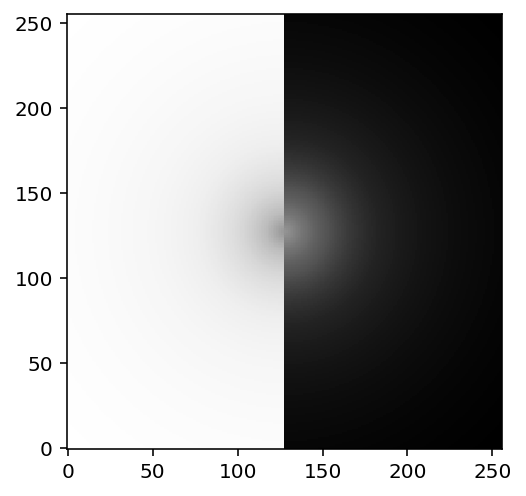

In [19]:
%matplotlib inline
plt.imshow(redshift_2D_map,cmap=plt.cm.Greys,origin="lower")

In [53]:
%matplotlib qt5
plt.imshow(redshift_2D_map*c_kms,cmap=plt.cm.Greys,origin="lower")

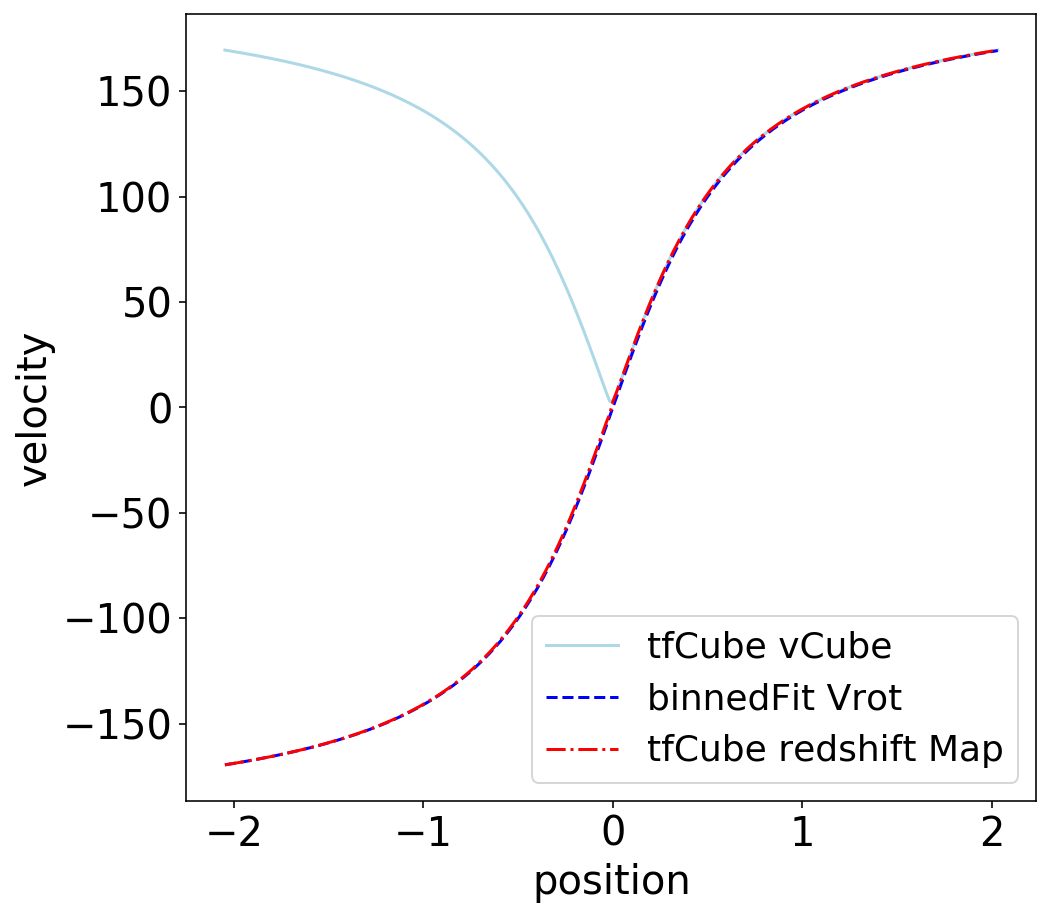

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, v_kms_1d, label='tfCube vCube', color='lightblue')

v_binnedFit = arctan_rotation(r=grid_pos, r_0=0., r_t=0.5, v_0=0., v_a=200.)
ax1.plot(grid_pos, v_binnedFit, label='binnedFit Vrot', color='b',ls='--')

ax1.plot(grid_pos, redshift_2D_map[128,:]*c_kms, label='tfCube redshift Map', color='r',ls='-.')
#ax1.plot(grid_pos, redshift_2D_map[:,128]*c_kms, label='tfCube redshift Map', color='r',ls='-.')
#ax1.plot(grid_pos, redshift_2D_map[:,127]*c_kms, label='tfCube redshift Map', color='r',ls='-.')


ax1.set_xlabel('position')
ax1.set_ylabel('velocity')

ax1.legend(loc='best',prop={'size':18})

In [32]:
xx[128,:]

array([-2.048     , -2.03193725, -2.01587451, -1.99981176, -1.98374902,
       -1.96768627, -1.95162353, -1.93556078, -1.91949804, -1.90343529,
       -1.88737255, -1.8713098 , -1.85524706, -1.83918431, -1.82312157,
       -1.80705882, -1.79099608, -1.77493333, -1.75887059, -1.74280784,
       -1.7267451 , -1.71068235, -1.69461961, -1.67855686, -1.66249412,
       -1.64643137, -1.63036863, -1.61430588, -1.59824314, -1.58218039,
       -1.56611765, -1.5500549 , -1.53399216, -1.51792941, -1.50186667,
       -1.48580392, -1.46974118, -1.45367843, -1.43761569, -1.42155294,
       -1.4054902 , -1.38942745, -1.37336471, -1.35730196, -1.34123922,
       -1.32517647, -1.30911373, -1.29305098, -1.27698824, -1.26092549,
       -1.24486275, -1.2288    , -1.21273725, -1.19667451, -1.18061176,
       -1.16454902, -1.14848627, -1.13242353, -1.11636078, -1.10029804,
       -1.08423529, -1.06817255, -1.0521098 , -1.03604706, -1.01998431,
       -1.00392157, -0.98785882, -0.97179608, -0.95573333, -0.93

In [33]:
yy[128,:]

array([0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803

In [ ]:
### check galIm

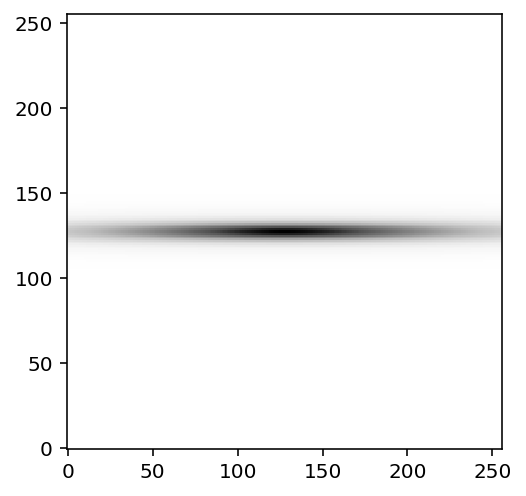

In [37]:
%matplotlib inline
plt.imshow(galIm.array,cmap=plt.cm.Greys,origin="lower")

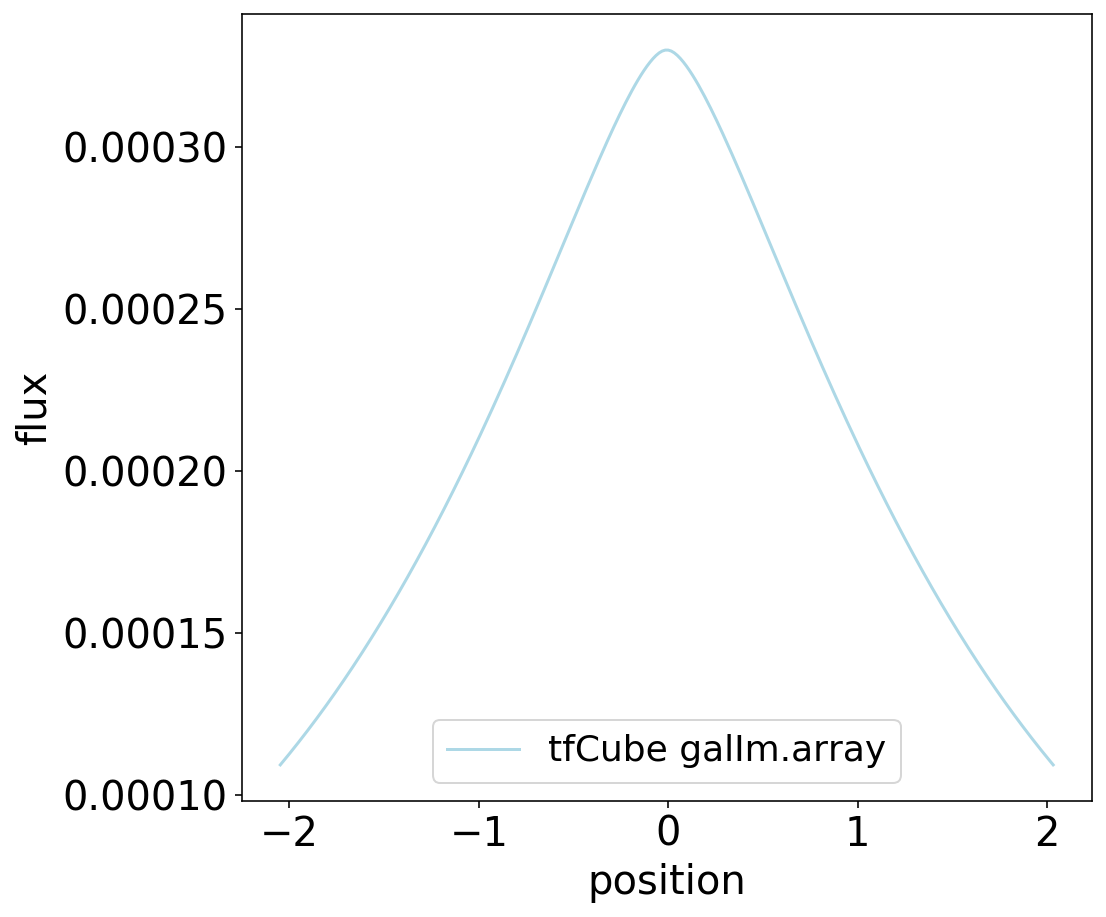

In [40]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, galIm.array[128,:], label='tfCube galIm.array', color='lightblue')

ax1.set_xlabel('position')
ax1.set_ylabel('flux')

ax1.legend(loc='best',prop={'size':18})